In [1]:
#Import python libraries

# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image


from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

,invasive
name,
1,0
2,0
3,1
4,0
5,1


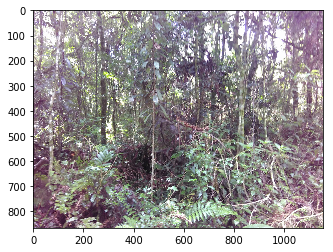

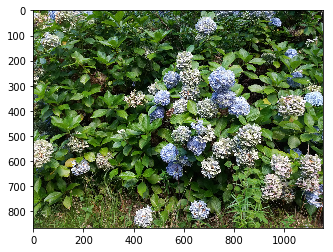

In [3]:
#2. display image of invaded and not invaded sites

# load the labels using pandas
labels = pd.read_csv("train_labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head(5))

def get_image(row_id, root="train/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just forest (not invaded site is 0.0) get the value of the third item in the index
forest_row = labels[labels.invasive == 0.0].index[2]

# show the corresponding image of forest
plt.imshow(get_image(forest_row))
plt.show()

# subset the dataframe to just kudzu (invaded site is 1.0) get the value of the third item in the index
kudzu_row = labels[labels.invasive == 1.0].index[2]

# show the corresponding image of a Bombus
plt.imshow(get_image(kudzu_row))
plt.show()

Color kudzu image has shape:  (866, 1154, 3)
Greyscale kudzu image has shape:  (866, 1154)


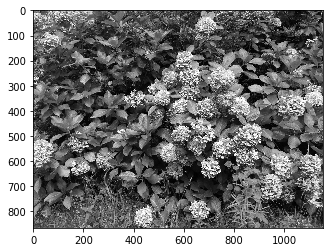

In [5]:
#3. Simplify image and convert to greyscale to explore further kudzu invaded images

# load images using our get_image function
kudzu = get_image(kudzu_row)


# print the shape of the bombus image
print('Color kudzu image has shape: ', kudzu.shape)

# convert the bombus image to greyscale
grey_kudzu = rgb2grey(kudzu)

# show the greyscale image
plt.imshow(grey_kudzu, cmap=mpl.cm.gray)

# greyscale bombus image only has one channel
print('Greyscale kudzu image has shape: ', grey_kudzu.shape)



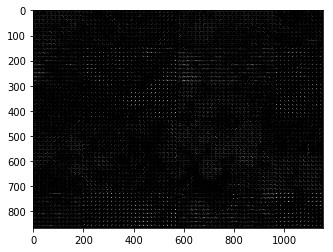

In [9]:
#4. Histogram of oriented gradients: shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients

# run HOG using greyscale kudzu image
hog_features, hog_image = hog(grey_kudzu,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a grey colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

In [10]:
#5. Create image features and flatten into a single row

def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features,hog_features))
    return flat_features

kudzu_features = create_features(kudzu)

# print shape
print(kudzu_features.shape)

(3292932,)


In [11]:
#6. Loop over images to preprocess

def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

IndexError: too many indices for array

In [ ]:
#7. Scale feature matrix + PCA

# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
invasive_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
invasive_pca = pca.fit_transform(invasive_stand)
# look at new shape
print('PCA matrix shape is: ', invasive_pca.shape)

In [ ]:
#8. Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(invasive_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=123)

# look at the distrubution of labels in the train set
value_counts=pd.Series(y_train)
value_counts

In [ ]:
# 9. Train model

# define support vector classifier
svm = SVC(probability=True,random_state=42)

# fit model
svm.fit(X_train,y_train)

In [ ]:
#10. Score model

# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_pred,y_test)
print('Model accuracy is: ', accuracy)

In [ ]:
#11. ROC curve + AUC

# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:,1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate,true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');